<a href="https://colab.research.google.com/github/fares-mldev/uns-ml2021/blob/main/tp7/ML_TP7_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Predicción de la clasificación de IMDB para películas

El objetivo de este proyecto es construir un modelo que prediga el puntaje de calificación de IMDB basado en atributos como duración, actores o incluso títulos. 

In [1]:
#@title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bz2
import pickle
import _pickle as cPickle

In [2]:
#@title Get Data

imdb_data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectIMDB/data/movie_metadata.csv")
imdb_data.head(15)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,Brad Garrett,Tangled,294810,2036,M.C. Gainey,1.0,17th century|based on fairy tale|disney|flower...,http://www.imdb.com/title/tt0398286/?ref_=fn_t...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,Chris Hemsworth,Avengers: Age of Ultron,462669,92000,Scarlett Johansson,4.0,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,Alan Rickman,Harry Potter and the Half-Blood Prince,321795,58753,Rupert Grint,3.0,blood|book|love|potion|professor,http://www.imdb.com/title/tt0417741/?ref_=fn_t...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


## Data preprocessing

In [3]:
#@title Data info

df = imdb_data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [4]:
#@title Numerical features
#@markdown Numerical values. Impute NaN as mean.

feature_names = []

columns_numeric = [
                   'num_critic_for_reviews',
                   'num_user_for_reviews',
                   'num_voted_users',
                   'duration',
                   'movie_facebook_likes',
                   'director_facebook_likes',
                   'actor_1_facebook_likes',
                   'actor_2_facebook_likes',
                   'actor_3_facebook_likes',
                   'cast_total_facebook_likes',
                   'facenumber_in_poster',
                   'gross',
                   'budget'
                   ]

# Numeric feature names
feature_names.extend(columns_numeric)

# Mean imputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df[columns_numeric] = imp.fit_transform(df[columns_numeric])

print(df[columns_numeric].info())
df[columns_numeric].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     5043 non-null   float64
 1   num_user_for_reviews       5043 non-null   float64
 2   num_voted_users            5043 non-null   float64
 3   duration                   5043 non-null   float64
 4   movie_facebook_likes       5043 non-null   float64
 5   director_facebook_likes    5043 non-null   float64
 6   actor_1_facebook_likes     5043 non-null   float64
 7   actor_2_facebook_likes     5043 non-null   float64
 8   actor_3_facebook_likes     5043 non-null   float64
 9   cast_total_facebook_likes  5043 non-null   float64
 10  facenumber_in_poster       5043 non-null   float64
 11  gross                      5043 non-null   float64
 12  budget                     5043 non-null   float64
dtypes: float64(13)
memory usage: 512.3 KB
None


,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,gross,budget
count,5043.000000,5043.000000,5.043000e+03,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5.043000e+03,5.043000e+03
mean,140.194272,272.770808,8.366816e+04,107.201074,7525.964505,686.509212,6560.047061,1651.754473,645.009761,9699.063851,1.371173,4.846841e+07,3.975262e+07
std,120.997229,377.194912,1.384853e+05,25.159932,19320.445110,2784.162531,15010.328553,4037.224104,1661.239692,18163.799124,2.010978,6.216318e+07,1.958004e+08
min,1.000000,1.000000,5.000000e+00,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.620000e+02,2.180000e+02
25%,50.000000,65.000000,8.593500e+03,93.000000,0.000000,7.000000,615.500000,281.000000,134.500000,1411.000000,0.000000,8.460992e+06,7.000000e+06
50%,111.000000,157.000000,3.435900e+04,103.000000,166.000000,52.000000,989.000000,596.000000,374.000000,3090.000000,1.000000,3.743230e+07,2.300000e+07
75%,194.000000,324.000000,9.630900e+04,118.000000,3000.000000,218.000000,11000.000000,919.000000,638.000000,13756.500000,2.000000,5.135707e+07,4.000000e+07
max,813.000000,5060.000000,1.689764e+06,511.000000,349000.000000,23000.000000,640000.000000,137000.000000,23000.000000,656730.000000,43.000000,7.605058e+08,1.221550e+10


In [5]:
#@title String categorical features
#@markdown Categorical values that admit only one simultaneous activation. Impute NaN as category 'UKN'.

# Column names
columns_categorical_str = ['color',
                           'language',
                           'country',
                           'content_rating',
                           'director_name',
                           'aspect_ratio',
                           'title_year']

#columns_categorical_all = columns_categorical_str + columns_categorical_multi_str

unique_values = {}

df[columns_categorical_str].fillna('UNK')

for column in columns_categorical_str:
  #Impute unknown values 
  df[column]=df[column].fillna('UNK') 
  
  # Get unique values
  values = list(df[column].unique())
  
  #values.sort()
  unique_values[column] = values

for column in columns_categorical_str:
  print(f'There are {len(unique_values[column])} distinct "{column}" values: ', unique_values[column][:5], '... \n')
    
  for uv in unique_values[column]:
    feature_names.append(column + '__' + str(uv)) 

len(feature_names)

There are 3 distinct "color" values:  ['Color', 'UNK', ' Black and White'] ... 

There are 48 distinct "language" values:  ['English', 'UNK', 'Japanese', 'French', 'Mandarin'] ... 

There are 66 distinct "country" values:  ['USA', 'UK', 'UNK', 'New Zealand', 'Canada'] ... 

There are 19 distinct "content_rating" values:  ['PG-13', 'UNK', 'PG', 'G', 'R'] ... 

There are 2399 distinct "director_name" values:  ['James Cameron', 'Gore Verbinski', 'Sam Mendes', 'Christopher Nolan', 'Doug Walker'] ... 

There are 23 distinct "aspect_ratio" values:  [1.78, 2.35, 'UNK', 1.85, 2.0] ... 

There are 92 distinct "title_year" values:  [2009.0, 2007.0, 2015.0, 2012.0, 'UNK'] ... 



2663

In [6]:
#@title Multi-String categorical features
#@markdown Categorical values that admit multiple simultaneous activations. Ignore NaN values.

# Column names
columns_categorical_multi_str = [
                                  'genres',
                                  'plot_keywords',
                                  'actors'
                                ]

# Impute NaN values
df['genres'] = df['genres'].fillna('UNK')
df['plot_keywords'] = df['plot_keywords'].fillna('UNK')
df['actor_1_name']=df['actor_1_name'].fillna('UNK')
df['actor_2_name']=df['actor_2_name'].fillna('UNK')
df['actor_3_name']=df['actor_3_name'].fillna('UNK')

# Unify actors in single column
df['actors']=''

for idx, row in df.iterrows():

  if row['actor_1_name'] != 'UNK':
    df.loc[idx,'actors'] = row['actor_1_name']

  if row['actor_2_name'] != 'UNK':
    df.loc[idx,'actors']+= '|'
    df.loc[idx,'actors']+=row['actor_2_name'] 

  if row['actor_3_name'] != 'UNK':
    df.loc[idx,'actors']+= '|'
    df.loc[idx,'actors']+=row['actor_2_name'] 

# Init genres, plot_keywords and actors set
set_genres = set()
set_plot_keywords = set() 
set_actors = set()
                              
for idx,row in df.iterrows():

  # Populate genres set
  list_genres = str(row['genres']).split('|')
  set_genres.update(list_genres)
  
  # Populate plot_keywords set
  list_plot_keywords = str(row['plot_keywords']).split('|')
  set_plot_keywords.update(list_plot_keywords)

  # Populate actors set
  if row['actors'] != '':
    list_actors = str(row['actors']).split('|')
    set_actors.update(list_actors)

sets = {'genres': set_genres, 
        'plot_keywords': set_plot_keywords, 
        'actors': set_actors}

for s in sets:
  print(f'There are {len(sets[s])} distinct "{s}" values: ', sets[s], '... \n')

  for fn in sets[s]:
    feature_names.append(s + '__' + str(fn)) 

len(feature_names)

There are 26 distinct "genres" values:  {'Western', 'Thriller', 'Sci-Fi', 'News', 'Crime', 'Sport', 'Comedy', 'Family', 'Documentary', 'Reality-TV', 'Romance', 'Musical', 'Game-Show', 'Film-Noir', 'Biography', 'Adventure', 'Horror', 'War', 'Short', 'Music', 'Animation', 'Action', 'Drama', 'History', 'Fantasy', 'Mystery'} ... 

There are 8087 distinct "plot_keywords" values:  {'land rover', 'casper', 'grifter', 'grimdark', 'phantom zone', 'hanging', 'notebook', 'mississippi river', 'silent movie', 'car damage', 'pac man', 'army', 'ark of the covenant', 'premature aging', 'conjoined twins', 'silent protagonist', 'mumbai riots', '10 year old', 'strike', 'flash mob', 'cult director', 'manifestation', 'clue', 'mediterranean', 'pool hall', 'tractor', 'ponzi scheme', 'yogi bear', 'sailing', 'victorian era', 'saviour', 'thin', 'ganja', 'delorean', 'symphony', 'flare', 'home', 'truck', 'theater critic', 'ghost story', 'manipulation', 'punishment', 'phantom', 'ray gun', 'football practice', 'are

14905

In [7]:
#@title Target { run: "auto" }

columns_target = ['imdb_score']
columns_label = ['movie_title']


In [8]:
#@title Prepare data for training / testing { run: "auto" }

from sklearn.model_selection import train_test_split

# Input colums
columns_categorical_all =  columns_categorical_str + \
                           columns_categorical_multi_str 
# Feature column names
columns_features = columns_numeric + \
                   columns_categorical_all


X = df[columns_features]
y = df[columns_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

X_train.head()

,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,gross,budget,color,language,country,content_rating,director_name,aspect_ratio,title_year,genres,plot_keywords,actors
2271,151.0,91.0,58957.0,117.0,0.0,20.0,11000.0,904.0,783.0,15713.0,1.0,13987482.0,20000000.0,Color,English,USA,R,Mark Mylod,1.85,2011,Comedy|Romance,ex boyfriend|morning after|prince charming|qua...,Chris Evans|Ari Graynor|Ari Graynor
3935,41.0,113.0,8535.0,99.0,872.0,60.0,979.0,665.0,444.0,3130.0,4.0,562059.0,4000000.0,Color,English,USA,R,Mars Callahan,1.85,2002,Drama|Thriller,beating|hustler|jail|money|revenge,Chazz Palminteri|Ricky Schroder|Ricky Schroder
2793,73.0,122.0,19805.0,93.0,0.0,85.0,1000.0,855.0,514.0,2777.0,0.0,15171475.0,8500000.0,Color,English,USA,R,Tom Holland,1.85,1996,Fantasy|Horror,death|doctor|gypsy|judge|lawyer,Joe Mantegna|Bethany Joy Lenz|Bethany Joy Lenz
482,35.0,88.0,22955.0,114.0,0.0,31.0,9000.0,496.0,372.0,10731.0,0.0,50628009.0,90000000.0,Color,English,USA,PG,Ron Underwood,1.85,1998,Action|Adventure|Family|Fantasy|Thriller,animal|california|gorilla|hunter|poacher,Charlize Theron|Mika Boorem|Mika Boorem
568,176.0,138.0,59352.0,112.0,0.0,72.0,11000.0,1000.0,715.0,13827.0,0.0,70224196.0,70000000.0,Color,English,USA,PG-13,Andy Tennant,2.35,2008,Action|Adventure|Comedy|Romance|Thriller,debt|rapper|treasure|treasure hunter|yacht,Matthew McConaughey|Ray Winstone|Ray Winstone


## Define training pipeline

In [9]:
#@title Preprocessing pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

class DummyTransformer(BaseEstimator, TransformerMixin):
    '''
    For debugging purposes
    '''

    def __init__(self, X):

      print('Dummy Constructor')
      self.X = X

    def fit(self, X, y=None):

      print('Dummy Fit')
      return self

    def transform(self, X, y=None):
      print('Dummy Transform')
      return X

class MultiHotTransformer(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical data that can take more than one value at the time
    '''

    def __init__(self, X):

      self.X = X
      self.setup(X)

    def setup(self,X):
      
      # Dictionary for storing indexes
      self.d = dict() 
      
      # List for storing column labels
      self.l = list()

      # Iterate over columns
      for col in X:

        #Initialize set
        s = set()

        # Iterate over samples and populate transform
        for x in X[col]:
          # Populate set
         l = str(x).split('|')
         s.update(l)

        # Empty dict
        self.d[col] = dict()

        # Iterate over set and store indexes in dictionary
        for idx, val in enumerate(s):
          self.d[col][val]=idx;
          self.l.append(col+'__'+val)
  
    def fit(self, X, y=None):

      return self

    def transform(self, X, y=None):

      # Initialize return vector  
      X_ret = None
      feats = dict()

      # Iterate over columns
      for col in X:

        feats[col]=[]

        # Iterate over elements 
        for x in X[col]:
          # init feature vector
          feat = np.zeros(len(self.d[col]))
          
          # Split string
          l = str(x).split('|')

          # Iterate over items
          for item in l:
            feat[self.d[col][item]]=1

          feats[col].append(feat)
        
        if X_ret is None:
          X_ret= np.array(feats[col])
        else:
          X_ret=np.hstack((X_ret,np.array(feats[col])))

      return np.array(X_ret)


def build_pre_cols(X,cols):
  '''
  Builds column processors
  '''
  num = StandardScaler()
  cat = MultiHotTransformer(X[cols])
  pre_cols = ColumnTransformer(
      transformers=[
          ('num', num, columns_numeric),
          ('cat', cat, columns_categorical_all),
          ])

  return pre_cols, columns_numeric + cat.l

def build_pre_cols_num(X,cols):
  '''
  Builds column processors
  '''
  num = StandardScaler()
  cat = MultiHotTransformer(X[cols])
  pre_cols = ColumnTransformer(
      transformers=[
          ('num', num, columns_numeric),
          ])

  return pre_cols, columns_numeric + cat.l

# Build column processor
pre_cols, feature_names = build_pre_cols(X,columns_categorical_all)
pre_cols_num, _ = build_pre_cols_num(X,columns_numeric)

# Show features
pd.DataFrame(pre_cols.fit_transform(X),columns=feature_names)


,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,gross,budget,color__UNK,color__Color,color__ Black and White,language__Icelandic,language__Danish,language__Mandarin,language__Aramaic,language__Tamil,language__Romanian,language__Zulu,language__Chinese,language__Kannada,language__Urdu,language__Kazakh,language__Slovenian,language__Greek,language__Hindi,language__Aboriginal,language__Korean,language__Russian,language__German,language__Hungarian,language__Italian,language__French,language__Spanish,language__Swedish,language__UNK,...,actors__Jenni 'Jwoww' Farley,actors__Richard Basehart,actors__Emily Baldoni,actors__Andrea Corr,actors__Robin Atkin Downes,actors__Frank Whaley,actors__Aidan Turner,actors__William Joseph Elk III,actors__Lloyd Avery II,actors__Mem Ferda,actors__Max Minghella,actors__Emmanuel Kabongo,actors__Temple Grandin,actors__Tom Wilkinson,actors__Julia Nickson,actors__Steve Duin,actors__Alan Williams,actors__Wilson Cruz,actors__Agnes Moorehead,actors__John Jarratt,actors__Nataniel Sánchez,actors__Kiernan Shipka,actors__Jaime King,actors__Tom Amandes,actors__Anthony 'Citric' Campos,actors__John Arcilla,actors__Florence Henderson,actors__Antony Starr,actors__R. Brandon Johnson,actors__Karl Malden,actors__Ray Milland,actors__Susan Chambers,actors__Regi Davis,actors__Marco St. John,actors__Mike Starr,actors__Chris Mulkey,actors__Richard Cabral,actors__Bud Cort,actors__Stephen McCole,actors__Dichen Lachman
0,4.817164,7.374185,5.795674,2.814234e+00,1.318632,-0.246601,-0.370451,-0.177306,0.126418,-0.267871,-0.681911,11.455463,1.007490,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.337401,2.559220,2.798784,2.456487e+00,-0.389572,-0.044366,2.228017,0.829426,0.213711,2.128121,-0.681911,4.198009,1.329278,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.817042,1.912276,1.388010,1.621744e+00,4.010348,-0.246601,0.295823,-0.311818,-0.291383,0.110172,-0.184592,2.439077,1.048352,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.561057,6.438236,7.659834,2.257739e+00,8.099687,7.656020,1.361861,5.288377,13.458146,5.344122,-0.681911,6.429881,1.073890,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,-0.604169,5.648769e-16,-0.389572,-0.199544,-0.428351,-0.406199,0.000000,-0.526157,-0.681911,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,-1.150506,-0.707319,-0.599684,-8.029862e-01,-0.38

In [10]:
#@title Training and evaluation functions 
#@markdown As performance metric we choose Mean Average Error (MAE), since it is commonly used in rating prediction systems.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# Initialize dictionary for model comparison

def build_linear(name,params,fs):
  
  model=dict()
  model['name']=name
  pre = Pipeline(steps=[
                      ('cols',pre_cols),
                      ('fs',fs)
                     ])
  
  model['params']=params
  
  model['pipeline']=Pipeline(steps=[('pre', pre),
                                    ('lr', LinearRegression())
                                   ])
  return model

def build_linear_num(name,params,fs):
  
  model=dict()
  model['name']=name
  pre = Pipeline(steps=[
                      ('cols',pre_cols_num),
                      ('fs',fs)
                     ])
  
  model['params']=params
  
  model['pipeline']=Pipeline(steps=[('pre', pre),
                                    ('lr', LinearRegression())
                                   ])
  return model

def build_ridge(name,params,fs):
  
  model=dict()
  
  model['name']=name
  
  model['params']=params
  
  pre = Pipeline(steps=[
                      ('cols',pre_cols),
                      ('fs',fs)
                     ])
  
  model['pipeline']=Pipeline(steps=[('pre', pre),
                                    ('ridge', Ridge())
                                   ])
  return model

def build_svr(name,params,fs):
  
  model=dict()
 
  model['name']=name
  
  model['params']=params

  pre = Pipeline(steps=[
                      ('cols',pre_cols),
                      ('fs',fs)
                     ])
    
  model['pipeline']=Pipeline(steps=[('pre', pre),
                                    ('svr', SVR())
                                   ])
  return model

def build_svr_num(name,params,fs):
  
  model=dict()
 
  model['name']=name
  
  model['params']=params

  pre = Pipeline(steps=[
                      ('cols',pre_cols_num),
                      ('fs',fs)
                     ])
    
  model['pipeline']=Pipeline(steps=[('pre', pre),
                                    ('svr', SVR())
                                   ])
  return model

def eval(model, X, y):
  '''
  Return eval metric
  '''
  y_pred = model.predict(X)
  return -mean_absolute_error(y,y_pred)

def train_eval(model,X_train,y_train,X_test,y_test):
  
  # Init metrics
  metrics = {}
  metrics['n_features']= []
  metrics['mae_train']= []
  metrics['mae_test']= []
  metrics['name'] = []
  metrics['param'] = []

  # Fit and eval
  for param in ParameterGrid(params):
      
    # Set training params
    model['pipeline'].set_params(**param)
    
    # Train model 
    model['pipeline'].fit(X_train,y_train)

    # Get metrics
    n_features = model['pipeline'].named_steps.pre['fs'].n
    mae_train = eval(model['pipeline'],X_train,y_train)
    mae_test = eval(model['pipeline'],X_test,y_test)

    print('name: ', model['name'],
          'params: ', param,
          'mae_train:' , f'{mae_train:.3f}' , 
          ' - ',
          'mae_test:' , f'{mae_test:.3f}')

    # Store metrics in dictionary
    metrics['name'].append(model['name'])
    metrics['param'].append(param)
    metrics['n_features'].append(n_features)
    metrics['mae_train'].append(mae_train)
    metrics['mae_test'].append(mae_test)

  model['metrics']=metrics

def train(model,params,X,y):

  # Metrics
  scoring = ['neg_mean_absolute_error']
  
  # Parameters
  model['params'] = params
  
  # Grid search
  gs = GridSearchCV(model['pipeline'],
                    param_grid=params,
                    scoring=scoring,
                    refit='neg_mean_absolute_error',
                    cv=5, 
                    return_train_score=True,
                    verbose=3)

  # Fit grid search
  model['trained'] = gs.fit(X,y.values.ravel())

  model['results'] = get_results(model)


def get_results(model):

  gs = model['trained']
  df_results = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')
  df_results['name']=model['name']

  df_results['n_features'] = model['trained'].best_estimator_['pre']['fs'].n

  result_cols = [ 'name',
                  'n_features',
                  'mean_fit_time',
                  'mean_score_time' ,
            	 	  'params',
                  'mean_test_neg_mean_absolute_error',
                 	'std_test_neg_mean_absolute_error',
                 	'rank_test_neg_mean_absolute_error',
                  'mean_train_neg_mean_absolute_error',
                  'std_train_neg_mean_absolute_error']

  return df_results[result_cols].sort_values(by='rank_test_neg_mean_absolute_error')

def plot_residuals(model,X,y,ax,label):

  y_pred = np.array(model.predict(X)).reshape(-1,1)
  y_true = np.array(y).reshape(-1,1) 
  res = y_pred-y_true
  ax.scatter(y_true,res,label=label)

def get_row_col(idx,ncols):
  row = idx // ncols
  col = idx % ncols
  return row,col

def compare_model_residuals(models,X_train,y_train,X_test,y_test):
  N = len(models)
  ncols = 3
  nrows = N//ncols+1

  fig,axs = plt.subplots(nrows,ncols) 
  fig.set_size_inches(5*ncols,6*nrows)

  for idx,model in enumerate(models):
    
    row,col = get_row_col(idx,ncols)

    mae_train = models[model]['trained'].cv_results_['mean_train_neg_mean_absolute_error'][0]
    mae_test = models[model]['trained'].cv_results_['mean_test_neg_mean_absolute_error'][0]
    
    axs[row,col].set_title(model + '\nmae (train): ' + f'{mae_train:.2f}'+ '\nmae (test): ' + f'{mae_test:.2f}')
    plot_residuals(models[model]['trained'],X_train,y_train,axs[row,col],label='train')
    plot_residuals(models[model]['trained'],X_test,y_test,axs[row,col],label='test')

In [11]:
#@title Baseline Feature Selector

def cols_2_mask(features,selected):
  '''
  Converts a list of selected column names to a mask in the feature vector 
  '''
  out = np.array([feature in selected for feature in features])
  return out

class FeatureSelectorTransformerBaseline(BaseEstimator, TransformerMixin):
    '''
    Selects features specified in a list of column names
    '''

    def __init__(self,mask):
      self.mask = mask
      self.n = np.sum(self.mask)

    def fit(self, X, y=None):

      return self

    def transform(self, X, y=None):

      # Slice feature vector
      return X[:,self.mask]


In [12]:
#@title F-Statistic Feature Selector

from sklearn.feature_selection import f_regression

#pipe.named_steps.selectfrommodel.get_params().keys() 
#pipe.named_steps.selectfrommodel.estimator.get_params().keys() 

# https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

def idx_2_mask(idxs,n):
  '''
  Creates a n-dimensional boolean array and sets to True elements specified in idxs 
  '''
  out = np.zeros(n,dtype=np.bool)
  for idx in idxs:
    out[idx]=True
  return out
  
def rank_features(metric):
  '''
  Creates a rank of features based on metric.
  Returns a dataframe containing original indexes with descending ordered metrics
  '''
  df = pd.DataFrame(list(zip(metric)),
                columns =['metric'])
  
  return df.sort_values(by='metric', ascending = False).reset_index()

class FeatureSelectorTransformerFReg(BaseEstimator, TransformerMixin):
    '''
    Selects features based on F-regression
    '''

    def __init__(self,n):
      self.n = n

    def fit(self, X, y=None):

      # Compute F-regression metric
      self.f_test, _ = f_regression(X, y)
      
      # Normalize metric coefficients
      self.f_test /= np.sum(self.f_test)

      # Rank features by metric
      self.rank = rank_features(self.f_test)

      # Selected indexes
      self.selected_idx = list(self.rank.head(self.n)['index'])
    
      # Create mask
      self.mask = idx_2_mask(self.selected_idx,X.shape[1])

      return self

    def transform(self, X, y=None):

      # Slice feature vector
      return X[:,self.mask]


In [13]:
#@title Forward Feature Selector

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge

class FeatureSelectorTransformerForward(BaseEstimator, TransformerMixin):
    '''
    Selects features based on Forward wrapper method
    '''

    def __init__(self,n=10):
      
      # Number of features to select
      self.n = n

    
    def fit(self, X, y=None):
      
      # Linear model to perform sequential feature selection
      self.ridge = Ridge(alpha=10)

      # Sequential Feature Selector 
      self.sfs = SequentialFeatureSelector(self.ridge, n_features_to_select=self.n,direction='forward')

      # Compute F-regression metric
      self.sfs.fit(X, y)
      
      # Create mask
      self.mask = self.sfs.get_support()

      return self

    def transform(self, X, y=None):

      # Slice feature vector
      return X[:,self.mask]



In [14]:
#@title Random Forest Selector

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

class FeatureSelectorTransformerRFR(BaseEstimator, TransformerMixin):
    '''
    Selects features based on Forward wrapper method
    '''

    def __init__(self,n=10,n_estimators=10):
      
      # Number of features to select
      self.n = n

      # Number of estimators for RandomForestRegressor
      self.n_estimators = n_estimators

    def fit(self, X, y=None):

      # Linear model to perform sequential feature selection
      self.rfr = RandomForestRegressor(n_estimators=self.n_estimators)

      # Sequential Feature Selector 
      self.sfm = SelectFromModel(self.rfr, 
                                 threshold=-np.inf,
                                 max_features=self.n,
                                 )
      
      # Compute F-regression metric
      self.sfm.fit(X, y)
      
      # Create mask
      self.mask = self.sfm.get_support()

      return self

    def transform(self, X, y=None):

      # Slice feature vector
      return X[:,self.mask]

# Column processors
num = StandardScaler()
cat = MultiHotTransformer(X[columns_categorical_all])
pre_cols = ColumnTransformer(
    transformers=[
        ('num', num, columns_numeric),
        ('cat', cat, columns_categorical_all),
        ])


In [15]:
#@title Lasso (L1) Regression Selector

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

class FeatureSelectorTransformerLasso(BaseEstimator, TransformerMixin):
    '''
    Selects features based on Forward wrapper method
    '''

    def __init__(self,alpha=0.01):
      
      # Number of estimators for RandomForestRegressor
      self.alpha = alpha

    def fit(self, X, y=None):

      # Linear model to perform sequential feature selection
      self.lasso = Lasso(alpha=self.alpha)

      # Sequential Feature Selector 
      self.sfm = SelectFromModel(self.lasso, threshold=1e-10)

      # Compute F-regression metric
      self.sfm.fit(X, y)
      
      # Create mask
      self.mask = self.sfm.get_support()

      # Number of selected features
      self.n = np.sum(self.mask)

      return self

    def transform(self, X, y=None):

      # Slice feature vector
      return X[:,self.mask]


## Baseline models

In [17]:
models = {}

In [18]:
#@title Baseline model 1 : Linear regression (numerical features)

# Feature selection
mask = cols_2_mask(feature_names,columns_numeric)
fs = FeatureSelectorTransformerBaseline(mask)

# Model tunable parameters
params = [{
              'lr__fit_intercept':[True]
          }]

# Build model
models['baseline_lr_num'] = build_linear('baseline_lr_num',params,fs)

# Train model
train(models['baseline_lr_num'],params,X_train,y_train)

# Show results
get_results(models['baseline_lr_num'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END lr__fit_intercept=True; neg_mean_absolute_error: (train=-0.747, test=-0.788) total time=   0.9s
[CV 2/5] END lr__fit_intercept=True; neg_mean_absolute_error: (train=-0.757, test=-0.751) total time=   0.7s
[CV 3/5] END lr__fit_intercept=True; neg_mean_absolute_error: (train=-0.770, test=-0.706) total time=   0.7s
[CV 4/5] END lr__fit_intercept=True; neg_mean_absolute_error: (train=-0.758, test=-0.760) total time=   0.7s
[CV 5/5] END lr__fit_intercept=True; neg_mean_absolute_error: (train=-0.748, test=-0.795) total time=   0.6s


,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,baseline_lr_num,13,0.587338,0.149423,{'lr__fit_intercept': True},-0.760042,0.031465,1,-0.7561,0.008316


In [19]:
#@title Baseline model 2 : Support vector regression (numerical features)

# Feature selection
mask = cols_2_mask(feature_names,columns_numeric)
fs = FeatureSelectorTransformerBaseline(mask)

# Model tunable parameters
params = [{
            'svr__C': [1,2,5,10],
            'svr__epsilon': [0.01],
            'svr__kernel': ['rbf']
          }]

# Build model
models['baseline_svr_num'] = build_svr('baseline_svr_num',params,fs)

# Train model
train(models['baseline_svr_num'],params,X_train,y_train)

# Show results
get_results(models['baseline_svr_num'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.599, test=-0.693) total time=   1.4s
[CV 2/5] END svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.607, test=-0.654) total time=   1.4s
[CV 3/5] END svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.613, test=-0.620) total time=   1.4s
[CV 4/5] END svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.605, test=-0.668) total time=   1.4s
[CV 5/5] END svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.593, test=-0.660) total time=   1.4s
[CV 1/5] END svr__C=2, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.579, test=-0.688) total time=   1.4s
[CV 2/5] END svr__C=2, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.586, test=-0.647) total time=   1.4s
[CV 3/5] END svr__C=2, 

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
2,baseline_svr_num,13,1.228391,0.274639,"{'svr__C': 5, 'svr__epsilon': 0.01, 'svr__kern...",-0.650987,0.018291,1,-0.556346,0.005118
3,baseline_svr_num,13,1.413544,0.271986,"{'svr__C': 10, 'svr__epsilon': 0.01, 'svr__ker...",-0.651753,0.014661,2,-0.536776,0.004541
1,baseline_svr_num,13,1.136547,0.270052,"{'svr__C': 2, 'svr__epsilon': 0.01, 'svr__kern...",-0.654604,0.021653,3,-0.582601,0.006154
0,baseline_svr_num,13,1.116694,0.271177,"{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kern...",-0.658852,0.023616,4,-0.603226,0.006966


In [20]:
#@title Baseline model 3 : Ridge regression (all features)
#@markdown The linear model with an elevated number of features and no regularization applied is prone to overfitting, so ridge regression was used instead

# Feature selection
mask = cols_2_mask(feature_names,feature_names)
fs = FeatureSelectorTransformerBaseline(mask)

# Model tunable parameters
params = [{
              'ridge__alpha':[5,10,20]
          }]

# Build model
models['baseline_ridge_all'] = build_ridge('baseline_ridge_all',params,fs)

# Train model
train(models['baseline_ridge_all'],params,X_train,y_train)

# Show results
get_results(models['baseline_ridge_all'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ridge__alpha=5; neg_mean_absolute_error: (train=-0.267, test=-0.617) total time=   5.4s
[CV 2/5] END ridge__alpha=5; neg_mean_absolute_error: (train=-0.274, test=-0.575) total time=   5.5s
[CV 3/5] END ridge__alpha=5; neg_mean_absolute_error: (train=-0.273, test=-0.568) total time=   5.6s
[CV 4/5] END ridge__alpha=5; neg_mean_absolute_error: (train=-0.271, test=-0.579) total time=   5.4s
[CV 5/5] END ridge__alpha=5; neg_mean_absolute_error: (train=-0.269, test=-0.606) total time=   5.4s
[CV 1/5] END ridge__alpha=10; neg_mean_absolute_error: (train=-0.350, test=-0.617) total time=   5.4s
[CV 2/5] END ridge__alpha=10; neg_mean_absolute_error: (train=-0.360, test=-0.572) total time=   5.4s
[CV 3/5] END ridge__alpha=10; neg_mean_absolute_error: (train=-0.360, test=-0.561) total time=   5.1s
[CV 4/5] END ridge__alpha=10; neg_mean_absolute_error: (train=-0.357, test=-0.579) total time=   5.2s
[CV 5/5] END ridge__alpha=1

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,baseline_ridge_all,14906,5.051447,0.178934,{'ridge__alpha': 10},-0.586068,0.020534,1,-0.356012,0.003575
2,baseline_ridge_all,14906,4.939694,0.167019,{'ridge__alpha': 20},-0.588408,0.022045,2,-0.433447,0.004232
0,baseline_ridge_all,14906,5.265689,0.205613,{'ridge__alpha': 5},-0.589027,0.019061,3,-0.270699,0.002825


In [40]:
#@title Baseline model 4 : Support vector regression (all features)

# Feature selection
mask = cols_2_mask(feature_names,feature_names)
fs = FeatureSelectorTransformerBaseline(mask)

# Preprocessor pipeline
pre = Pipeline(steps=[
                      ('cols',pre_cols),
                      ('fs',fs)
                     ])

# Model tunable parameters
params = [{
            'svr__C': [5],
            'svr__epsilon': [0.01],
            'svr__kernel': ['rbf']
          }]

# Build model
models['baseline_svr_all'] = build_svr('baseline_svr_all',params,fs)

# Train model
train(models['baseline_svr_all'],params,X_train,y_train)

# Show results
get_results(models['baseline_svr_all'])

# Pop result from comparison
#_ = models.pop('baseline_svr_all')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.024, test=-0.561) total time= 1.9min
[CV 2/5] END svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.027, test=-0.523) total time= 1.9min
[CV 3/5] END svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.027, test=-0.493) total time= 2.0min
[CV 4/5] END svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.028, test=-0.513) total time= 1.9min
[CV 5/5] END svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.026, test=-0.541) total time= 1.8min


,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,baseline_svr_all,14906,73.765709,39.646677,"{'svr__C': 5, 'svr__epsilon': 0.01, 'svr__kern...",-0.526132,0.023483,1,-0.026094,0.001374


## Filter methods - F-Statistic

In [22]:
#@title Train Ridge with F-Statistic feature selection

# Feature selection
fs = FeatureSelectorTransformerFReg(n=10)

# Other way
# sklearn.feature_selection.SelectKBest(
#        score_func=sklearn.feature_selection.f_regression,
#        k=25)),

# Preprocessor pipeline
pre = Pipeline(steps=[
                      ('cols',pre_cols),
                      ('fs',fs)
                     ])

# Model tunable parameters
params = [{
              'pre__fs__n': [50,100,200,500,1000],
              'ridge__alpha':[10]
          }]

# Build model
models['freg_ridge'] = build_ridge('freg_ridge',params,fs)

# Train model
train(models['freg_ridge'],params,X_train,y_train)

# Show results
get_results(models['freg_ridge'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.731, test=-0.777) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.741, test=-0.739) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.753, test=-0.695) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.741, test=-0.750) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.735, test=-0.772) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.717, test=-0.765) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.727, test=-0.728) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.739, test=-0.682) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.726, test=-0.740) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.720, test=-0.761) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=200, ridge__alpha=10; neg_mean_absolute_error: (train=-0.687, test=-0.741) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=200, ridge__alpha=10; neg_mean_absolute_error: (train=-0.695, test=-0.708) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=200, ridge__alpha=10; neg_mean_absolute_error: (train=-0.709, test=-0.656) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=200, ridge__alpha=10; neg_mean_absolute_error: (train=-0.699, test=-0.714) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=200, ridge__alpha=10; neg_mean_absolute_error: (train=-0.691, test=-0.730) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=500, ridge__alpha=10; neg_mean_absolute_error: (train=-0.678, test=-0.737) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=500, ridge__alpha=10; neg_mean_absolute_error: (train=-0.686, test=-0.708) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=500, ridge__alpha=10; neg_mean_absolute_error: (train=-0.699, test=-0.655) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=500, ridge__alpha=10; neg_mean_absolute_error: (train=-0.690, test=-0.713) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=500, ridge__alpha=10; neg_mean_absolute_error: (train=-0.683, test=-0.726) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=1000, ridge__alpha=10; neg_mean_absolute_error: (train=-0.664, test=-0.735) total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=1000, ridge__alpha=10; neg_mean_absolute_error: (train=-0.673, test=-0.704) total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=1000, ridge__alpha=10; neg_mean_absolute_error: (train=-0.685, test=-0.654) total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=1000, ridge__alpha=10; neg_mean_absolute_error: (train=-0.677, test=-0.709) total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=1000, ridge__alpha=10; neg_mean_absolute_error: (train=-0.669, test=-0.723) total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
4,freg_ridge,1000,0.809640,0.171934,"{'pre__fs__n': 1000, 'ridge__alpha': 10}",-0.704986,0.027805,1,-0.673884,0.007050
3,freg_ridge,1000,0.725671,0.151901,"{'pre__fs__n': 500, 'ridge__alpha': 10}",-0.707730,0.028429,2,-0.687343,0.007155
2,freg_ridge,1000,0.688050,0.147430,"{'pre__fs__n': 200, 'ridge__alpha': 10}",-0.709851,0.029226,3,-0.696126,0.007503
1,freg_ridge,1000,0.694496,0.152542,"{'pre__fs__n': 100, 'ridge__alpha': 10}",-0.735025,0.029990,4,-0.725993,0.007607
0,freg_ridge,1000,0.688251,0.157658,"{'pre__fs__n': 50, 'ridge__alpha': 10}",-0.746653,0.029635,5,-0.740088,0.007346


In [23]:
#@title Train SVR with F-Statistic feature selection

# Feature selection
fs = FeatureSelectorTransformerFReg(n=10)

# Model tunable parameters
params = [{
            'pre__fs__n': [50,100,200,500,1000],
            'svr__C': [5],
            'svr__epsilon': [0.01],
            'svr__kernel': ['rbf']
          }]

# Build model
models['freg_svr'] = build_svr('freg_svr',params,fs)

# Train model
train(models['freg_svr'],params,X_train,y_train)

# Show results
get_results(models['freg_svr'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.533, test=-0.673) total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.542, test=-0.635) total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.545, test=-0.618) total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.541, test=-0.649) total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.530, test=-0.636) total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.515, test=-0.671) total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.525, test=-0.633) total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.530, test=-0.601) total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.524, test=-0.641) total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.512, test=-0.640) total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=200, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.459, test=-0.651) total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=200, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.468, test=-0.627) total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=200, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.474, test=-0.585) total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=200, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.469, test=-0.612) total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=200, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.459, test=-0.617) total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=500, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.430, test=-0.647) total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=500, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.437, test=-0.625) total time=   5.7s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=500, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.443, test=-0.580) total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=500, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.439, test=-0.617) total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=500, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.431, test=-0.613) total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 1/5] END pre__fs__n=1000, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.379, test=-0.648) total time=   8.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 2/5] END pre__fs__n=1000, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.389, test=-0.625) total time=   9.0s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 3/5] END pre__fs__n=1000, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.393, test=-0.579) total time=   8.9s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 4/5] END pre__fs__n=1000, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.391, test=-0.612) total time=   8.7s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV 5/5] END pre__fs__n=1000, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.382, test=-0.611) total time=   8.8s


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
4,freg_svr,1000,6.645196,2.191307,"{'pre__fs__n': 1000, 'svr__C': 5, 'svr__epsilo...",-0.615127,0.022299,1,-0.386794,0.005156
3,freg_svr,1000,3.947992,1.116325,"{'pre__fs__n': 500, 'svr__C': 5, 'svr__epsilon...",-0.616487,0.021702,2,-0.435962,0.004825
2,freg_svr,1000,1.879313,0.561601,"{'pre__fs__n': 200, 'svr__C': 5, 'svr__epsilon...",-0.618337,0.021632,3,-0.465969,0.005962
1,freg_svr,1000,1.607549,0.388679,"{'pre__fs__n': 100, 'svr__C': 5, 'svr__epsilon...",-0.637075,0.022386,4,-0.520883,0.006650
0,freg_svr,1000,1.476099,0.322441,"{'pre__fs__n': 50, 'svr__C': 5, 'svr__epsilon'...",-0.642269,0.018232,5,-0.538084,0.005553


##Wrapper methods: Forward selection

In [24]:
#@title Train Linear with Forward feature selection (numerical features)
#@markdown Since Forward feature selection is computationally consuming on the complete dataset, we try it on the numerical features only

# Feature selection
fs = FeatureSelectorTransformerForward()

# Model tunable parameters
params = [{
              'pre__fs__n': [5,6,7,8,9,10,11,12],
              'lr__fit_intercept':[True]
          }]

# Build model
models['forward_lr'] = build_linear_num('forward_lr',params,fs)

# Train model
train(models['forward_lr'],params,X_train[columns_numeric],y_train)

# Show results
get_results(models['forward_lr'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END lr__fit_intercept=True, pre__fs__n=5; neg_mean_absolute_error: (train=-0.758, test=-0.796) total time=   0.4s
[CV 2/5] END lr__fit_intercept=True, pre__fs__n=5; neg_mean_absolute_error: (train=-0.768, test=-0.766) total time=   0.4s
[CV 3/5] END lr__fit_intercept=True, pre__fs__n=5; neg_mean_absolute_error: (train=-0.779, test=-0.717) total time=   0.4s
[CV 4/5] END lr__fit_intercept=True, pre__fs__n=5; neg_mean_absolute_error: (train=-0.769, test=-0.767) total time=   0.4s
[CV 5/5] END lr__fit_intercept=True, pre__fs__n=5; neg_mean_absolute_error: (train=-0.761, test=-0.799) total time=   0.4s
[CV 1/5] END lr__fit_intercept=True, pre__fs__n=6; neg_mean_absolute_error: (train=-0.755, test=-0.794) total time=   0.5s
[CV 2/5] END lr__fit_intercept=True, pre__fs__n=6; neg_mean_absolute_error: (train=-0.765, test=-0.758) total time=   0.5s
[CV 3/5] END lr__fit_intercept=True, pre__fs__n=6; neg_mean_absolute_error: (tr

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
6,forward_lr,11,0.730245,0.004849,"{'lr__fit_intercept': True, 'pre__fs__n': 11}",-0.759897,0.032176,1,-0.756704,0.007756
7,forward_lr,11,0.743342,0.004386,"{'lr__fit_intercept': True, 'pre__fs__n': 12}",-0.760043,0.031475,2,-0.756071,0.008342
3,forward_lr,11,0.608998,0.003751,"{'lr__fit_intercept': True, 'pre__fs__n': 8}",-0.761205,0.030585,3,-0.760108,0.007970
2,forward_lr,11,0.564153,0.004561,"{'lr__fit_intercept': True, 'pre__fs__n': 7}",-0.761875,0.030246,4,-0.760886,0.007833
4,forward_lr,11,0.644828,0.003755,"{'lr__fit_intercept': True, 'pre__fs__n': 9}",-0.761926,0.030580,5,-0.760042,0.007964
5,forward_lr,11,0.689634,0.004230,"{'lr__fit_intercept': True, 'pre__fs__n': 10}",-0.762091,0.029975,6,-0.759381,0.007913
1,forward_lr,11,0.513316,0.003801,"{'lr__fit_intercept': True, 'pre__fs__n': 6}",-0.765856,0.030141,7,-0.763940,0.007815
0,forward_lr,11,0.415048,0.003813,"{'lr__fit_intercept': True, 'pre__fs__n': 5}",-0.768901,0.029701,8,-0.766836,0.007286


In [25]:
#@title Train SVR with Forward feature selection (numerical features)

# Feature selection
fs = FeatureSelectorTransformerForward(mask)

# Preprocessor pipeline
pre = Pipeline(steps=[
                      ('cols',pre_cols),
                      ('fs',fs)
                     ])

# Model tunable parameters
params = [{
            'pre__fs__n': [5,6,7,8,9,10,11,12],
            'svr__C': [5],
            'svr__epsilon': [0.01],
            'svr__kernel': ['rbf'],
          }]

# Build model
models['forward_svr'] = build_svr_num('forward_svr',params,fs)

# Train model
train(models['forward_svr'],params,X_train,y_train)

# Show results
get_results(models['forward_svr'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END pre__fs__n=5, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.620, test=-0.703) total time=   1.1s
[CV 2/5] END pre__fs__n=5, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.627, test=-0.693) total time=   1.1s
[CV 3/5] END pre__fs__n=5, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.645, test=-0.639) total time=   1.2s
[CV 4/5] END pre__fs__n=5, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.633, test=-0.666) total time=   1.1s
[CV 5/5] END pre__fs__n=5, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.621, test=-0.691) total time=   1.1s
[CV 1/5] END pre__fs__n=6, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.605, test=-0.696) total time=   1.2s
[CV 2/5] END pre__fs__n=6, svr__C=5, svr__epsilon=0.01, svr__kernel=rb

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
2,forward_svr,7,1.307912,0.157689,"{'pre__fs__n': 7, 'svr__C': 5, 'svr__epsilon':...",-0.665216,0.028459,1,-0.600578,0.006983
6,forward_svr,7,1.444284,0.148610,"{'pre__fs__n': 11, 'svr__C': 5, 'svr__epsilon'...",-0.665264,0.029313,2,-0.580127,0.013709
3,forward_svr,7,1.259611,0.146720,"{'pre__fs__n': 8, 'svr__C': 5, 'svr__epsilon':...",-0.667657,0.026221,3,-0.597718,0.007046
7,forward_svr,7,1.468139,0.151714,"{'pre__fs__n': 12, 'svr__C': 5, 'svr__epsilon'...",-0.668311,0.027566,4,-0.573419,0.011687
4,forward_svr,7,1.325153,0.139766,"{'pre__fs__n': 9, 'svr__C': 5, 'svr__epsilon':...",-0.672711,0.026732,5,-0.590680,0.006004
1,forward_svr,7,1.086649,0.132980,"{'pre__fs__n': 6, 'svr__C': 5, 'svr__epsilon':...",-0.673537,0.023239,6,-0.613748,0.007483
5,forward_svr,7,1.363803,0.142993,"{'pre__fs__n': 10, 'svr__C': 5, 'svr__epsilon'...",-0.673602,0.028415,7,-0.588600,0.005827
0,forward_svr,7,1.010345,0.130404,"{'pre__fs__n': 5, 'svr__C': 5, 'svr__epsilon':...",-0.678360,0.022989,8,-0.629283,0.009429


## Embedded Methods

In [27]:
#@title Train Ridge with Random Forest feature selection

# Feature selection
fs = FeatureSelectorTransformerRFR()

# Model tunable parameters
params = [{
              'pre__fs__n': [50,100,200,500,1000],
              'ridge__alpha':[10]
          }]

# Build model
models['rfr_ridge'] = build_ridge('rfr_ridge',params,fs)

# Train model
train(models['rfr_ridge'],params,X_train,y_train)

# Show results
get_results(models['rfr_ridge'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.607, test=-0.666) total time=  11.9s
[CV 2/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.623, test=-0.611) total time=  12.3s
[CV 3/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.622, test=-0.606) total time=  13.9s
[CV 4/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.624, test=-0.633) total time=  13.0s
[CV 5/5] END pre__fs__n=50, ridge__alpha=10; neg_mean_absolute_error: (train=-0.613, test=-0.646) total time=  12.0s
[CV 1/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.583, test=-0.652) total time=  12.0s
[CV 2/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.599, test=-0.603) total time=  11.8s
[CV 3/5] END pre__fs__n=100, ridge__alpha=10; neg_mean_absolute_error: (train=-0.605, test=-0.587) total time=  12.2s
[

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
4,rfr_ridge,1000,12.165567,0.151769,"{'pre__fs__n': 1000, 'ridge__alpha': 10}",-0.594306,0.022911,1,-0.522622,0.005220
3,rfr_ridge,1000,11.974881,0.149845,"{'pre__fs__n': 500, 'ridge__alpha': 10}",-0.596006,0.021977,2,-0.544408,0.007597
2,rfr_ridge,1000,12.111828,0.152785,"{'pre__fs__n': 200, 'ridge__alpha': 10}",-0.601036,0.021886,3,-0.571577,0.008300
1,rfr_ridge,1000,12.082750,0.144023,"{'pre__fs__n': 100, 'ridge__alpha': 10}",-0.617738,0.022670,4,-0.594697,0.007678
0,rfr_ridge,1000,12.453910,0.163847,"{'pre__fs__n': 50, 'ridge__alpha': 10}",-0.632574,0.022301,5,-0.617741,0.006816


In [28]:
#@title Train SVR with Random Forest Regressor feature selection

# Feature selection
fs = FeatureSelectorTransformerRFR()

# Model tunable parameters
params = [{
            'pre__fs__n': [50,100,200,500,1000],
            'svr__C': [5],
            'svr__epsilon': [0.01],
            'svr__kernel': ['rbf']
          }]

# Build model
models['rfr_svr'] = build_svr('rfr_svr',params,fs)

# Train model
train(models['rfr_svr'],params,X_train,y_train)

# Show results
get_results(models['rfr_svr'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.353, test=-0.577) total time=  13.1s
[CV 2/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.359, test=-0.541) total time=  13.3s
[CV 3/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.363, test=-0.509) total time=  13.5s
[CV 4/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.354, test=-0.544) total time=  13.2s
[CV 5/5] END pre__fs__n=50, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.337, test=-0.571) total time=  13.1s
[CV 1/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.284, test=-0.572) total time=  13.5s
[CV 2/5] END pre__fs__n=100, svr__C=5, svr__epsilon=0.01, svr__

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
3,rfr_svr,500,15.867528,1.245428,"{'pre__fs__n': 500, 'svr__C': 5, 'svr__epsilon...",-0.533552,0.022889,1,-0.177759,0.007131
4,rfr_svr,500,19.557545,2.572448,"{'pre__fs__n': 1000, 'svr__C': 5, 'svr__epsilo...",-0.536178,0.020825,2,-0.127650,0.004944
2,rfr_svr,500,13.593889,0.615788,"{'pre__fs__n': 200, 'svr__C': 5, 'svr__epsilon...",-0.541564,0.024107,3,-0.246832,0.009334
1,rfr_svr,500,13.012578,0.388490,"{'pre__fs__n': 100, 'svr__C': 5, 'svr__epsilon...",-0.542011,0.021858,4,-0.299130,0.010361
0,rfr_svr,500,12.920885,0.324775,"{'pre__fs__n': 50, 'svr__C': 5, 'svr__epsilon'...",-0.548347,0.024216,5,-0.353333,0.008958


In [29]:
#@title Train Ridge with Lasso (L1) feature selection

# Feature selection
fs = FeatureSelectorTransformerLasso()

# Model tunable parameters
params = [{
            'pre__fs__alpha': [0.0005,0.001,0.005,0.01,0.05],
            'ridge__alpha':[10]
          }]

# Build model
models['lasso_ridge'] = build_ridge('lasso_ridge',params,fs)

# Train model
train(models['lasso_ridge'],params,X_train,y_train)

# Show results
get_results(models['lasso_ridge'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END pre__fs__alpha=0.0005, ridge__alpha=10; neg_mean_absolute_error: (train=-0.466, test=-0.624) total time=  14.4s
[CV 2/5] END pre__fs__alpha=0.0005, ridge__alpha=10; neg_mean_absolute_error: (train=-0.474, test=-0.574) total time=  16.5s
[CV 3/5] END pre__fs__alpha=0.0005, ridge__alpha=10; neg_mean_absolute_error: (train=-0.474, test=-0.565) total time=  23.7s
[CV 4/5] END pre__fs__alpha=0.0005, ridge__alpha=10; neg_mean_absolute_error: (train=-0.474, test=-0.592) total time=   6.1s
[CV 5/5] END pre__fs__alpha=0.0005, ridge__alpha=10; neg_mean_absolute_error: (train=-0.471, test=-0.601) total time=  14.3s
[CV 1/5] END pre__fs__alpha=0.001, ridge__alpha=10; neg_mean_absolute_error: (train=-0.517, test=-0.631) total time=   3.2s
[CV 2/5] END pre__fs__alpha=0.001, ridge__alpha=10; neg_mean_absolute_error: (train=-0.528, test=-0.587) total time=   4.8s
[CV 3/5] END pre__fs__alpha=0.001, ridge__alpha=10; neg_mean_absolu

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,lasso_ridge,798,14.819035,0.171480,"{'pre__fs__alpha': 0.0005, 'ridge__alpha': 10}",-0.591161,0.020882,1,-0.471884,0.003127
1,lasso_ridge,798,3.679881,0.165123,"{'pre__fs__alpha': 0.001, 'ridge__alpha': 10}",-0.596834,0.022404,2,-0.525604,0.005005
2,lasso_ridge,798,2.607187,0.168660,"{'pre__fs__alpha': 0.005, 'ridge__alpha': 10}",-0.610844,0.024313,3,-0.592809,0.006807
3,lasso_ridge,798,1.960318,0.161996,"{'pre__fs__alpha': 0.01, 'ridge__alpha': 10}",-0.627369,0.028588,4,-0.613499,0.005980
4,lasso_ridge,798,1.202401,0.173937,"{'pre__fs__alpha': 0.05, 'ridge__alpha': 10}",-0.703990,0.029104,5,-0.699528,0.008843


In [30]:
#@title Train SVR with Lasso Regressor feature selection

# Feature selection
fs = FeatureSelectorTransformerLasso()

# Model tunable parameters
params = [{
            'pre__fs__alpha': [0.0005,0.001,0.005,0.01,0.05],
            'svr__C': [5],
            'svr__epsilon': [0.01],
            'svr__kernel': ['rbf']
          }]

# Build model
models['lasso_svr'] = build_svr('lasso_svr',params,fs)

# Train model
train(models['lasso_svr'],params,X_train,y_train)

# Show results
get_results(models['lasso_svr'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END pre__fs__alpha=0.0005, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.092, test=-0.561) total time=  23.0s
[CV 2/5] END pre__fs__alpha=0.0005, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.105, test=-0.532) total time=  23.4s
[CV 3/5] END pre__fs__alpha=0.0005, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.101, test=-0.507) total time=  35.4s
[CV 4/5] END pre__fs__alpha=0.0005, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.109, test=-0.530) total time=  14.1s
[CV 5/5] END pre__fs__alpha=0.0005, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.096, test=-0.558) total time=  21.8s
[CV 1/5] END pre__fs__alpha=0.001, svr__C=5, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.176, test=-0.566) total time=   5.8s
[CV 2/5] END pre_

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,lasso_svr,798,21.392790,2.139636,"{'pre__fs__alpha': 0.0005, 'svr__C': 5, 'svr__...",-0.537808,0.020108,1,-0.100493,0.005971
1,lasso_svr,798,5.659996,0.717283,"{'pre__fs__alpha': 0.001, 'svr__C': 5, 'svr__e...",-0.538257,0.020634,2,-0.187275,0.006844
2,lasso_svr,798,3.709973,0.350535,"{'pre__fs__alpha': 0.005, 'svr__C': 5, 'svr__e...",-0.540508,0.021931,3,-0.322762,0.004117
3,lasso_svr,798,2.974945,0.324019,"{'pre__fs__alpha': 0.01, 'svr__C': 5, 'svr__ep...",-0.558684,0.026097,4,-0.370488,0.008524
4,lasso_svr,798,1.959388,0.284312,"{'pre__fs__alpha': 0.05, 'svr__C': 5, 'svr__ep...",-0.644065,0.031382,5,-0.567514,0.005656


In [47]:
#@title Save trained models
#https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2

def save_pickle(fn, data):
  with open(fn, "wb") as f:
    pickle.dump(data, f)

def compress_pickle(fn, data):
  with bz2.BZ2File(fn + '.pbz2', 'w') as f: 
    cPickle.dump(data, f)

save_pickle('models.pkl', models)
compress_pickle('models', models)

## Model Comparison

For model comparison visualization we plot each model in the fit time (negative fit time for normalization) vs. metric (neg_mean_absolute_error) space. Higher values in each cordinate represents a better performance.

In [33]:
#@title Load trained models

def load_models(fn):
  with open(fn, "rb") as f:
    models = pickle. load(f)
  return models

def decompress_pickle(fn):
 data = bz2.BZ2File(fn + '.pbz2', 'rb')
 data = cPickle.load(data)
 return data

models = load_models('models.pkl')
models = decompress_pickle('models')

In [44]:
#@title Model results - Table

# Get results of individual models
frames = [get_results(models[model]).sort_values(by='mean_test_neg_mean_absolute_error', ascending =False).head(1) for model in models]

#for frame in frames:
#  frame=frame.sort_values(by='mean_test_neg_mean_absolute_error', ascending =False).head(1)

# Join datasets
df_compare = pd.concat(frames)

# Select best model of each type
df_compare = df_compare[df_compare['rank_test_neg_mean_absolute_error'] == 1]

# Sort by ranking metric
df_compare = df_compare.sort_values(by = 'mean_test_neg_mean_absolute_error', ascending = False)

df_compare

,name,n_features,mean_fit_time,mean_score_time,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,baseline_svr_all,14906,73.765709,39.646677,"{'svr__C': 5, 'svr__epsilon': 0.01, 'svr__kern...",-0.526132,0.023483,1,-0.026094,0.001374
3,rfr_svr,500,15.867528,1.245428,"{'pre__fs__n': 500, 'svr__C': 5, 'svr__epsilon...",-0.533552,0.022889,1,-0.177759,0.007131
0,lasso_svr,798,21.392790,2.139636,"{'pre__fs__alpha': 0.0005, 'svr__C': 5, 'svr__...",-0.537808,0.020108,1,-0.100493,0.005971
1,baseline_ridge_all,14906,5.051447,0.178934,{'ridge__alpha': 10},-0.586068,0.020534,1,-0.356012,0.003575
0,lasso_ridge,798,14.819035,0.171480,"{'pre__fs__alpha': 0.0005, 'ridge__alpha': 10}",-0.591161,0.020882,1,-0.471884,0.003127
4,rfr_ridge,1000,12.165567,0.151769,"{'pre__fs__n': 1000, 'ridge__alpha': 10}",-0.594306,0.022911,1,-0.522622,0.005220
4,freg_svr,1000,6.645196,2.191307,"{'pre__fs__n': 1000, 'svr__C': 5, 'svr__epsilo...",-0.615127,0.022299,1,-0.386794,0.005156
2,baseline_svr_num,13,1.228391,0.274639,"{'svr__C': 5, 'svr__epsilon': 0.01, 'svr__kern...",-0.650987,0.018291,1,-0.556346,0.005118
2,forward_svr,7,1.307912,0.157689,"{'pre__fs__n': 7, 'svr__C': 5, 'svr__epsilon':...",-0.665216,0.028459,1,-0.600578,0.006983
4,freg_ridge,1000,0.809640,0.171934,"{'pre__fs__n': 1000, 'ridge__alpha': 10}",-0.704986,0.027805,1,-0.673884,0.007050


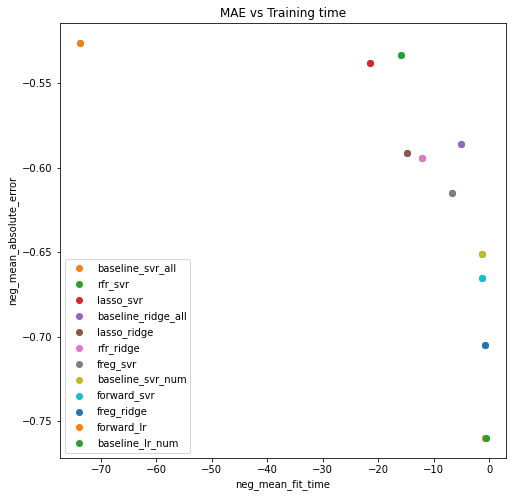

In [45]:
#@title Model results - Validation metric vs Training time

fig= plt.gcf()
ax = plt.gca()

fig.set_size_inches(8,8)

ax.scatter(-df_compare['mean_fit_time'],df_compare['mean_test_neg_mean_absolute_error'])

for idx,row in df_compare.iterrows():
  ax.scatter(-row['mean_fit_time'],row['mean_test_neg_mean_absolute_error'],label=row['name'])

_ = ax.set_xlabel('neg_mean_fit_time')
_ = ax.set_ylabel('neg_mean_absolute_error')
_ = ax.legend()
_ = ax.set_title('MAE vs Training time')

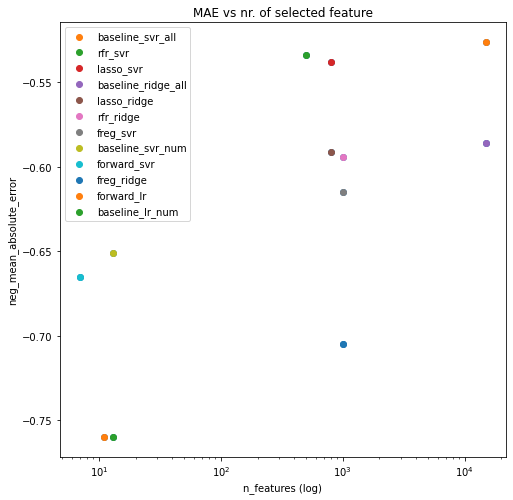

In [46]:
#@title Model results - Validation metric  vs Number of selected features

fig= plt.gcf()
ax = plt.gca()

fig.set_size_inches(8,8)

ax.scatter(df_compare['n_features'],df_compare['mean_test_neg_mean_absolute_error'])

for idx,row in df_compare.iterrows():
  ax.scatter(row['n_features'],row['mean_test_neg_mean_absolute_error'],label=row['name'])
  ax.set_xscale('log')

_ = ax.set_xlabel('n_features (log)')
_ = ax.set_ylabel('neg_mean_absolute_error')
_ = ax.legend()
_ = ax.set_title('MAE vs nr. of selected feature')

#Conclusions

The baseline models `baseline_lr_num` and `baseline_svr_num` were trained with only numerical features. 

When trained with all features, linear regression showed to be prone of overfitting, so ridge regression (L2 regularization) was used instead, obtaining fairly good results (`baseline_ridge_all`) at moderate training times.

The baseline for SVR `baseline_svr_all` took > 2min to complete each training, with a mean perfromance metric of -0.52, showing some signs of overfitting (significant gap between training and test metrics). Probably this could be improved by a better hyperparameter search, but due to the long training times it was not developed further in this work. 

Filter F-Statistic method (`freg_*`) showed a poor performance metric compared to embedded methods, while being significantly faster to compute.

The wrapper method of forward selection (`forward_*`), being computationally intensive, showed to be innapropiate for the full dataset and was applied only to the numerical columns. 

Best performance metric was obtained with embedded methods, random forest and lasso feature selection (`rfr_*` and `lasso_*`), giving only a slightly inferior metric performance than the baseline with a > x10 feature number reduction and a x4 training speed up.

In general, there was a significant gap (.1 mae) observed between the `ridge` and `svr` models.

A more efficient number of feature selection could be obtained by plotting the mae vs number of features curve and selecting the optimal operation point using the elbow method. 
